# 目标检测和边界框
在图像分类任务中，我们假设图像中只有一个主要物体对象，我们只关注如何识别其类别。然而，很多时候图像里有多个我们感兴趣的目标，**我们不仅想知道它们的类别，还想得到它们在图像中的具体位置**。在计算机视觉里，我们将这类任务称为*目标检测*（object detection）或*目标识别*（object recognition）。

目标检测在多个领域中被广泛使用。例如，在无人驾驶里，我们需要通过识别拍摄到的视频图像里的车辆、行人、道路和障碍物的位置来规划行进线路。机器人也常通过该任务来检测感兴趣的目标。安防领域则需要检测异常目标，如歹徒或者炸弹。

在接下来的几节中，我们将介绍几种用于目标检测的深度学习方法。
我们将首先介绍目标的*位置*。

## 边界框（Bounding-box）
在目标检测中，我们通常使用*边界框*（bounding box）来描述对象的空间位置。
通常边界框是矩形的，有两种表示方法：
* 由矩形左上角的以及右下角的$x$和$y$坐标决定。
* 边界框中心的$(x, y)$轴坐标以及框的宽度和高度。


在这里，我们[**定义在这两种表示法之间进行转换的函数**]：`box_corner_to_center`从两角表示法转换为中心宽度表示法，而`box_center_to_corner`反之亦然。
输入参数`boxes`可以是长度为4的张量，也可以是形状为（$n$，4）的二维张量，其中$n$是边界框的数量。

先加载本节要使用的实例图像：

In [2]:
from PIL import Image
img = Image.open('./catdog.jpg')

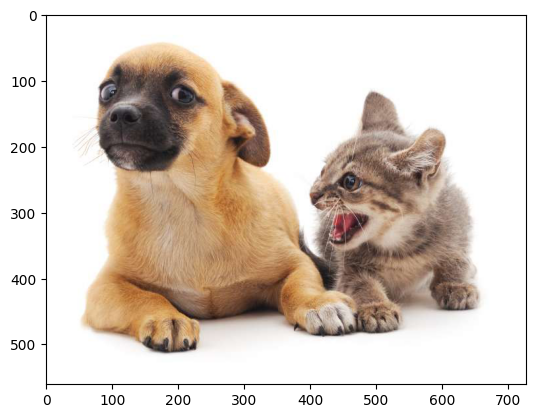

In [4]:
import matplotlib.pyplot as plt
plt.imshow(img)

定义两种边界框相互转换的函数：

In [19]:
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes  = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [6]:
import torch

**注意一下torch.stack()的用法：**

In [7]:
x1 = torch.tensor([1, 2,3, 4,5,6,])
y1 = torch.tensor([21,123,31,123,213,23])
torch.stack((x1, y1), axis=-1)

tensor([[  1,  21],
        [  2, 123],
        [  3,  31],
        [  4, 123],
        [  5, 213],
        [  6,  23]])

我们将根据坐标信息定义图像中狗和猫的边界框。
**图像中坐标的原点是图像的左上角，向右的方向为$x$轴的正方向，向下的方向为$y$轴的正方向**。


In [11]:
# bbox是边界框的英文缩写
# 下面两个是corner box
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

我们可以通过转换两次来验证边界框转换函数的正确性。先把corner box转换为center box， 再把center box转换为corner box。

In [16]:
boxes = torch.tensor((dog_bbox, cat_bbox))

In [21]:
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

接下来我们将边界框画出来，定义一个辅助函数bbox_to_rect，它将顶点边界框表示成matplotlib的边界框格式，也就是将边界框**(左上x,左上y,右下x,右下y)**格式转换成matplotlib格式:**((左上x,左上y),宽,高)**。

In [22]:
def bbox_to_rect(bbox, color):
    return plt.Rectangle(
            xy=(bbox[0], bbox[1]),
            width=bbox[2] - bbox[0], height=bbox[3] - bbox[1],
            fill=False, edgecolor=color, linewidth=2)

在图像上添加边界框之后，我们可以看到两个物体的主要轮廓基本上在两个框内。


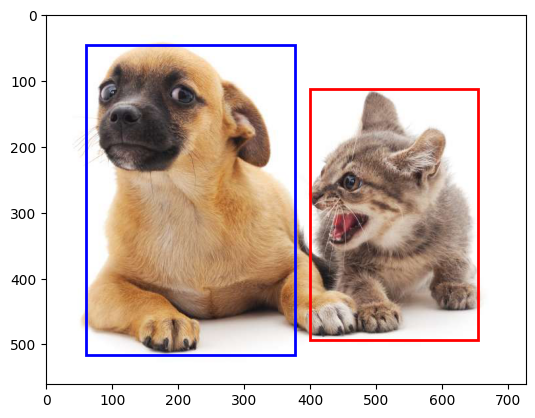

In [23]:
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))

## 小结
* 目标检测不仅可以识别图像中所有感兴趣的物体，还能识别它们的位置，该位置通常由矩形边界框表示。
* 两种常用的边界框表示：（x1, y1, x2, y2）和（cx, cy, w, h)。
* 用plt.Rectangle()绘制边界框时，需要把边界框表示成（x1, y1, w, h）的格式。